In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import seaborn as sns
import scipy.signal as signal
from scipy.fft import fft
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

In [2]:
def fill_trailing_zeros_with_max(arr):
    result = arr.copy()
    for i, row in enumerate(result):
        max_val = np.max(row)
        
        # Find indices of non-zero elements
        nonzero_indices = np.nonzero(row)[0]
        
        if len(nonzero_indices) > 0:
            # Get the index after the last non-zero element
            last_nonzero_idx = nonzero_indices[-1]
            # Fill trailing zeros
            result[i, last_nonzero_idx + 1:] = max_val
    
    return result


def apply_padding(array, padding_length, position="left", paddign_value=0):
    padding_base = np.ones((array.shape[0], padding_length))

    if type(paddign_value) is not int and type(paddign_value) is not float: 
        if len(paddign_value) != array.shape[0]:
            raise ValueError("Padding value must match the number of columns in the array.")
        else:
            padding = (padding_base.T * paddign_value).T
    else:
        padding = padding_base * paddign_value

    if position == "left":
        return np.concatenate((padding, array), axis=1)
    elif position == "right":
        return np.concatenate((array, padding), axis=1)
    elif position == "both":
        return np.concatenate((padding, array, padding), axis=1)
    else:
        raise ValueError("Position must be 'left', 'right', or 'both'.")

In [3]:
# open the file with energy depositions
max_len = 1600
n_signals = 5

energy_depositions = np.zeros((n_signals, max_len))

dict_signals = {}

with open("signals_gesim.txt", "r") as f:
    for line in f:
        kay = str(line.strip()[0:8])
        val = line.strip()[11:-1]
        dict_signals[kay] = val

for idx, kay in enumerate(dict_signals.keys()):
    tmp = dict_signals[kay]
    tmp = tmp.replace(" ", "")
    tmp = tmp.replace("eV", "")
    tmp = tmp.split(",")
    for i in range(len(tmp)):
        energy_depositions[idx, i] = float(tmp[i])


# extend the max value of the energy deposition in the original array
energy_depositions_tailed = fill_trailing_zeros_with_max(energy_depositions)

# apply padding at the beginning of the array (baseline)
padding_length_baseline = int(22400*0.2)
energy_depositions_padded = apply_padding(energy_depositions_tailed, padding_length_baseline, position="left", paddign_value=0)    # baseline

# applay padding at the end of the array (tail)
max_energy = []
for i in range(n_signals):
    max_energy.append(np.max(energy_depositions_padded[i]))
tails = np.array(max_energy) 
padding_length_tail = int(22400*0.8)
energy_depositions_padded = apply_padding(energy_depositions_padded, padding_length_tail, position="right", paddign_value=tails) # tail


In [4]:
q = 1.6e-19
W = 1
R = 10000e9

current = np.gradient(energy_depositions_padded, axis=1)/W * q  # in A
voltage = current * R

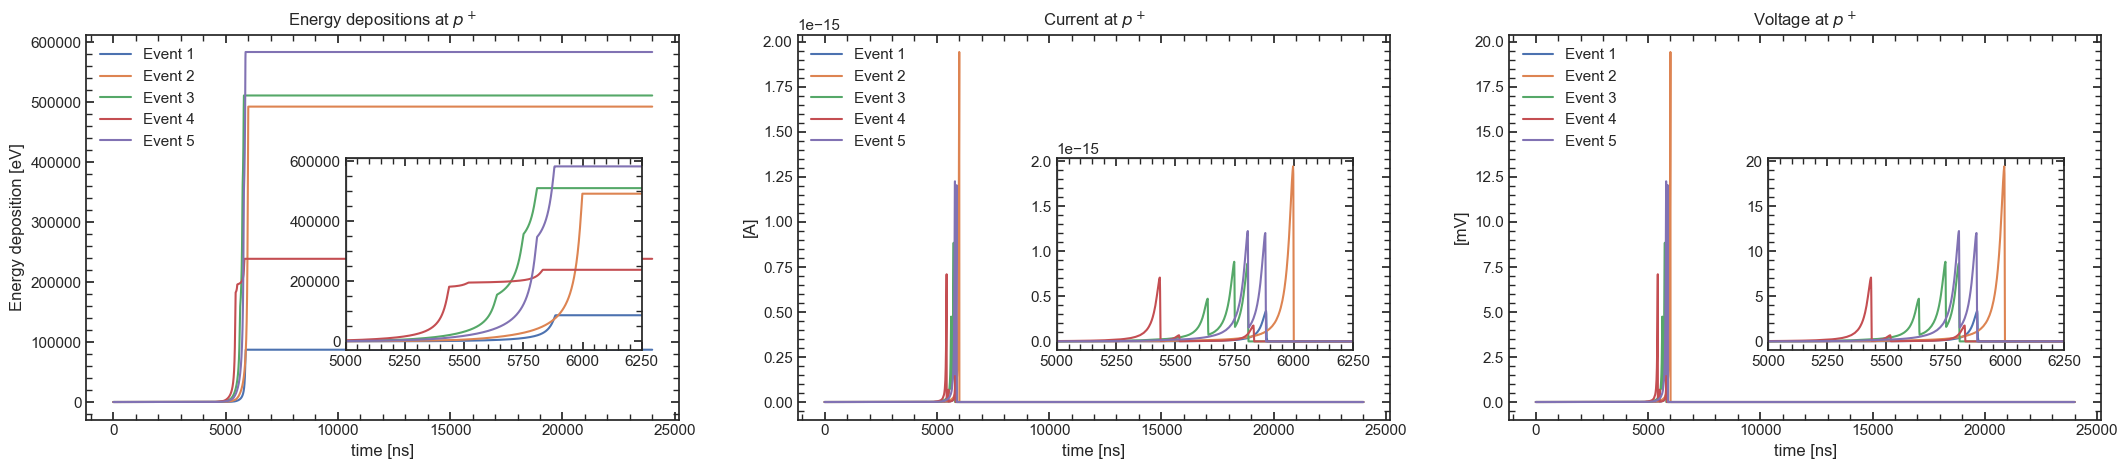

In [5]:
plt.figure(figsize=(26, 5))  

plt.subplot(1, 3, 1)
plt.title("Energy depositions at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("Energy deposition [eV]")

for i in range(n_signals):
    plt.plot(energy_depositions_padded[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.3, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(energy_depositions_padded[i], label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.subplot(1, 3, 2)
plt.title("Current at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("[A]")

for i in range(n_signals):
    plt.plot(current[i], label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.3, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(current[i], label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.subplot(1, 3, 3)
plt.title("Voltage at $p^+$")
plt.xlabel("time [ns]")
plt.ylabel("[mV]")

for i in range(n_signals):
    plt.plot(voltage[i]*1e3, label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.3, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(n_signals):
    axins.plot(voltage[i]*1e3, label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

-------

In [7]:
with open('total_transfer_function_params.pkl', 'rb') as f:
    total_transfer_loaded = pickle.load(f)

with open('calibration_curve_params.pkl', 'rb') as f:
    calibration_curve_loaded = pickle.load(f)

def integrate_signal(R_f, C_f, input_signal, dt, decay=True):
        tau = R_f * C_f             
        offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
        output_signal = np.zeros_like(input_signal)
        effective_signal = input_signal - offset  

        if decay:
            decay_factor = np.exp(-dt /tau)
        else: decay_factor = 1

        for i in range(1, len(input_signal)):
            input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / (2 * C_f)
            output_signal[i] = output_signal[i-1] * decay_factor + input_contribution
        
        return -output_signal

def spectrum(wf,points=int(1000),fs=1):
    """
    Computes the frequency spectrum of a waveform.
    
    Args:
        wf (array): waveform
        points (int): number of points in the psd
        fs (int): sampling frequency
        
    Returns:
        array: frequency
        array: amplitude
        array: phase
    """
    spect = fft(wf,n=2*(points-1),axis=0)
    amp = np.abs(spect/fs/len(wf))
    amp = amp[:int(len(spect)/2+1)]
    amp[1:] = 2*amp[1:]
    phase = np.angle(spect[:int(len(spect)/2+1)])
    freq=np.arange(0,fs/2,fs/2/len(amp))
    return freq,amp,phase


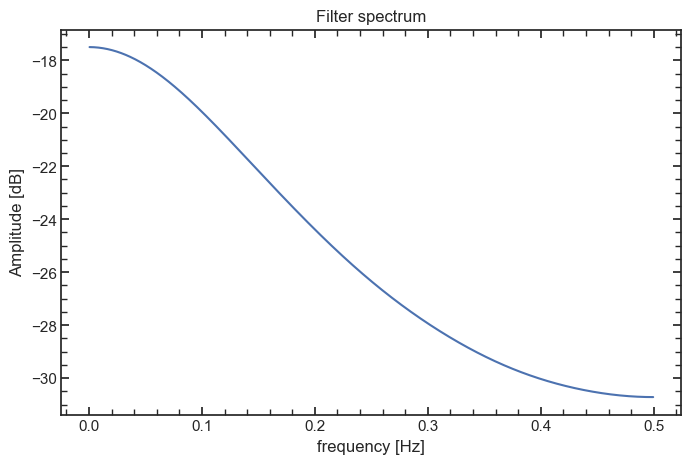

In [8]:
f_h = 5e6 # Hz
f_s = 62.5e6 # Hz

w_h = 2 * np.pi * f_h
w_s = 2 * np.pi * f_s

low_len = 15 # Length of the FIR filter
f_cut = f_h/f_s # Relative Cut frequency for the filter


filter = signal.firwin(numtaps=low_len, cutoff=f_cut, window='exponential')
freq, amp, __ = spectrum(filter, points=1000)

plt.figure(figsize=(8, 5))
plt.title("Filter spectrum")
plt.xlabel("frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.plot(freq[1:], 20*np.log10(amp[1:]), label="Filter response");

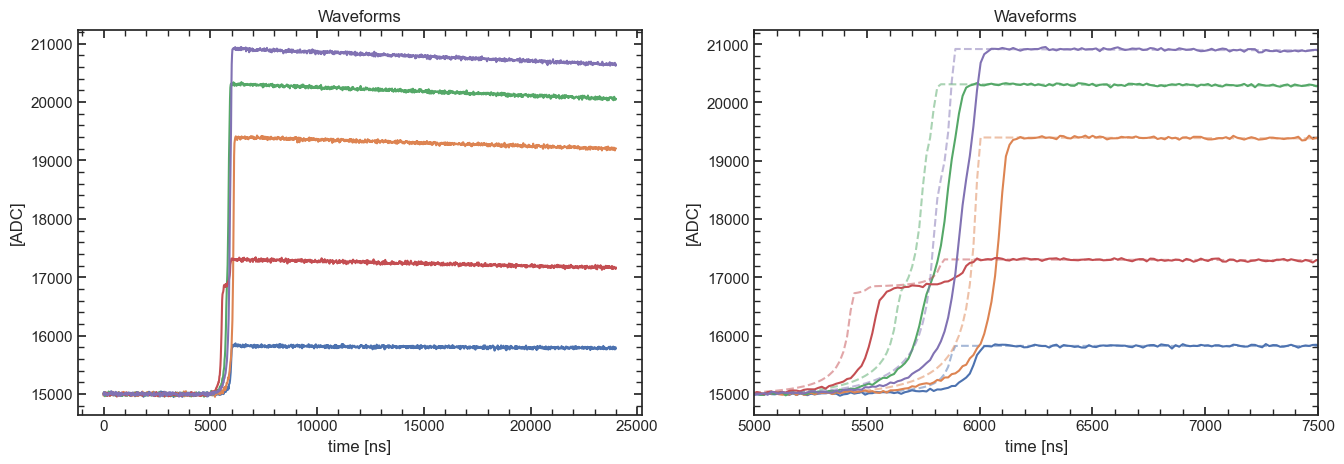

In [9]:
signal_sampled = voltage[:, ::16]
time = np.linspace(0, (max_len + 22400)*1e-9, 1500) # ns
dt = time[1] - time[0]

sigma = 0.0001

ADC_to_V = 0.13/(20e3)
V_to_ADC = 1/ADC_to_V

R_f = 1e9
C_f = 400e-15
dc_bias = -3.52
ADC_bias = 15000

plt.figure(figsize=(16, 5))

plt.subplot(1,2,1)
plt.title("Waveforms")
plt.xlabel("time [ns]")
plt.ylabel("[ADC]")

for i in range(n_signals):
    noise = np.random.normal(0, sigma, signal_sampled.shape[1])
    input_signal = signal_sampled[i,:] + dc_bias
    output_csa = total_transfer_loaded(input_signal)
    integrated_signal = integrate_signal(R_f, C_f, output_csa, dt, decay=True)
    conversion = calibration_curve_loaded(integrated_signal)
    waveform = (np.array([s*c for s,c in zip(integrated_signal, conversion)]))
    waveform_final = np.convolve(waveform, filter)[:-low_len+1] + noise # apply filter

    plt.plot(time*1e9, (waveform_final*V_to_ADC)+ ADC_bias)
    #plt.plot(time*1e9, (waveform*V_to_ADC)+ ADC_bias, ls='--')

plt.subplot(1,2,2)
plt.title("Waveforms")
plt.xlabel("time [ns]")
plt.ylabel("[ADC]")

for i in range(n_signals):
    noise = np.random.normal(0, sigma, signal_sampled.shape[1])
    input_signal = signal_sampled[i,:] + dc_bias
    output_csa = total_transfer_loaded(input_signal)
    integrated_signal = integrate_signal(R_f, C_f, output_csa, dt, decay=True)
    conversion = calibration_curve_loaded(integrated_signal)
    waveform = (np.array([s*c for s,c in zip(integrated_signal, conversion)]))
    waveform_final = np.convolve(waveform, filter)[:-low_len+1] + noise # apply filter

    line1 = plt.plot(time*1e9, (waveform_final*V_to_ADC)+ ADC_bias)
    color = line1[0].get_color()
    plt.plot(time*1e9, (waveform*V_to_ADC)+ ADC_bias, ls ='--', color=color, alpha=0.5)
plt.xlim(5000, 7500);